# How likely are you to die if you take the vax?

That is the question that I am going to attempt to tackle here.
I must admit that I am not a healthcare professional or work in the healthcare industry.
This is solely and academic exercise and the results should not be relied upon for any healthcare decisions.

> Consult with your primary health provider for any medical decisions.

## Problem description

In order to attempt to answer the question, I used data that I collected from [Vaccine Adverse Event Reporting System (VAERS)](https://vaers.hhs.gov/) which is an arm of the [U.S. Department of Health & Human Services (HHS)](https://www.hhs.gov/).

The datasets can be downloaded from: [VAERS Data Sets](https://vaers.hhs.gov/data/datasets.html).

I'm currently only using the data for this year, 2022, since the data from 2021 is around 3X larger!

## Import the required packages

In [1]:
import json
import pickle
import random
import re
import warnings

import bentoml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, mutual_info_score, roc_auc_score, roc_curve,
)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier
from tqdm.auto import tqdm

import xgboost as xgb

warnings.filterwarnings("ignore")
%matplotlib inline

## Import the datasets

In [2]:
# import datasets
data_dataset = 'data/2022VAERSDATA.csv'
vax_dataset = 'data/2022VAERSVAX.csv'
# codecs: latin, latin1, cp1252, ISO-8859-1
dates = ['RECVDATE', 'RPT_DATE', 'DATEDIED', 'VAX_DATE', 'ONSET_DATE', 'TODAYS_DATE']
data = pd.read_csv(data_dataset, parse_dates=dates, encoding='cp1252')
vdata = pd.read_csv(vax_dataset, encoding='cp1252')

# merge datasets based on id
data.set_index('VAERS_ID', inplace=True)
vdata.set_index('VAERS_ID', inplace=True)
df = pd.merge(data, vdata, left_index=True, right_index=True)

# keep only covid vaxs
vax_types = ['COVID19', 'COVID19-2']
df = df[df['VAX_TYPE'].isin(vax_types)]

## Clean up the data

In [3]:
df.head()

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,...,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
1996874,2022-01-01,NaN,NaN,NaN,NaN,U,NaT,SUSPECTED CLINICAL VACCINATION FAILURE; SUSPEC...,NaN,NaT,...,NaN,NaN,NaN,COVID19,JANSSEN,NaN,1,OT,NaN,COVID19 (COVID19 (JANSSEN))
1996875,2022-01-01,OH,NaN,NaN,NaN,M,NaT,SUSPECTED CLINICAL VACCINATION FAILURE; SUSPEC...,NaN,NaT,...,NaN,NaN,NaN,COVID19,JANSSEN,204A21A,1,NaN,NaN,COVID19 (COVID19 (JANSSEN))
1996876,2022-01-01,MS,34.0,NaN,NaN,F,NaT,Irregular menstrual cycle.; period extremely h...,NaN,NaT,...,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,Fd8448,2,NaN,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
1996877,2022-01-01,CT,NaN,NaN,NaN,F,NaT,Breakthrough and heavy periods; longer period ...,NaN,NaT,...,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,EP6955,1,NaN,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
1996878,2022-01-01,NaN,74.0,NaN,NaN,M,NaT,tired; Patient reports feeling achy; chills; t...,NaN,NaT,...,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,NaN,3,NaN,NaN,COVID19 (COVID19 (PFIZER-BIONTECH))


> Since I'm trying to predict if someone will die from taking the shot, I needed to remove any features that the patient would not know before taking the shot or the ones that I thought would not play a significant role in the outcome.

In [4]:
drop_features = [
    'BIRTH_DEFECT',
    'CAGE_MO',
    'CAGE_YR',
    'DATEDIED',
    'ER_ED_VISIT',
    'ER_VISIT',
    'FORM_VERS',
    'HOSPDAYS',
    'HOSPITAL',
    'LAB_DATA',
    'NUMDAYS',
    'ONSET_DATE',
    'RECOVD',
    'RECVDATE',
    'RPT_DATE',
    'SPLTTYPE',
    'SYMPTOM_TEXT',
    'TODAYS_DATE',
    'VAX_DATE',
    'VAX_LOT',
    'VAX_NAME',
    'VAX_ROUTE',
    'VAX_SITE',
    'VAX_TYPE',
    'V_ADMINBY',
    'V_FUNDBY',
    'X_STAY',
]
binarize_features = ['allergies', 'cur_ill', 'history', 'other_meds', 'prior_vax']
binary_features = ['died', 'l_threat', 'disable', 'ofc_visit']
other_features = ['v_fundby']
none_values = {
    '"none" per patient',
    '"unidentified" per grandmother',
    '(does not apply)',
    ',none',
    '-',
    '- nka',
    '- nkda',
    '- none',
    '- none known',
    '--- 1/6/2022 10:48 pm --- nka',
    '-na-',
    '...',
    '2no',
    '?',
    'allergies: nka',
    'decline',
    'denied',
    'denies',
    'denies any allergies to medications,foods',
    'denies.',
    'did not indicate.',
    'did not provide any information.',
    'dka.',
    'do not know',
    "don't know",
    'done',
    'i do not',
    "i don't know",
    "i don't want to add anything.",
    'kna',
    'known',
    'm/a',
    'mkda',
    'mom reported no allergies',
    'mom stated no on admission',
    'mone',
    'n / a',
    "n'a",
    'n-a',
    'n./a',
    'n.a',
    'n.a.',
    'n.k.a',
    'n.k.d. a',
    'n.k.d.a',
    'n.k.d.a.',
    'n/',
    'n/a',
    'n/a - none',
    'n/a per mother',
    'n/a to the best of my knowledge',
    'n/a unknown',
    'n/a.',
    'n/a. pt did not verbalize any allergies.',
    'n/k',
    'n/k/a',
    'n0',
    'n?a',
    'na',
    'na/',
    'nak',
    'ndka',
    'ndka, nka',
    'ndka.',
    'never',
    'nil',
    'nk',
    'nka',
    'nka  knda',
    'nka  reported by father',
    'nka / nkda',
    'nka as per mother',
    'nka nkda',
    'nka no food or drug allergies otherwise noted',
    'nka reported',
    'nka to meds, unknown to others',
    'nka until this 3rd (booster) vaccine',
    'nka, knda, no known environmental or food allergies.',
    'nka, none reported.',
    'nka.',
    'nka/nkda',
    'nkda',
    'nkda  nkfa',
    'nkda at the time',
    'nkda listed in patient profile.',
    'nkda listed on form.',
    'nkda nka',
    'nkda nkfa',
    'nkda no food allergies either',
    'nkda no known food allergies',
    'nkda no other allergies',
    'nkda or allergies reported',
    'nkda or to foods.',
    'nkda reported',
    'nkda, food allergies, or other products',
    'nkda, food allergy, or other allergy',
    'nkda, kkfa',
    'nkda, nka',
    'nkda, nkea.',
    'nkda, nkfa',
    'nkda, no environmental allergies, no food allergies',
    'nkda, no food allergies',
    'nkda, no known allergies',
    'nkda, no known food allergies',
    'nkda, no known food or product allergies',
    'nkda, no known other allergies.',
    'nkda, no reported food allergies',
    'nkda, none',
    'nkda.',
    'nkda/ no known foord allergies',
    'nkda/nka',
    'nkda/nkfa',
    'nkda/no know allergies',
    'nkda; nka',
    'nkda; nkfa',
    'nkda; nkfa.',
    'nkda; no allergies to food or any other products',
    'nkda= no',
    'nkda`',
    'nkdfa',
    'nkfda',
    'nkma',
    'nkma / no food allergies',
    'nkma and no food',
    'nkma.',
    'nkma/nka',
    'nknda',
    'nkne',
    'nknown',
    'no',
    'no  not that aware of.',
    'no according to patient questionnaire',
    'no active allergies',
    'no adverse reactions reported',
    'no allegies',
    'no allergic reactions to vaccines.',
    'no allergies',
    'no allergies any medications and food',
    'no allergies at the moment.',
    'no allergies at the time',
    'no allergies at the time of vaccination.',
    'no allergies currently.',
    'no allergies documented',
    'no allergies found so far.',
    'no allergies indicated',
    'no allergies listed at time of vaccine.',
    'no allergies listed for medications,food components, vaccine components, or latex',
    'no allergies noted',
    'no allergies on file',
    'no allergies per mom',
    'no allergies per patient informed consent form',
    'no allergies per screening checklist',
    'no allergies per vaccination checklist',
    'no allergies reported',
    'no allergies reported by parent.',
    'no allergies reported.',
    'no allergies s at the moment.',
    'no allergies stated;nka',
    'no allergies to any food or medications were reported.',
    'no allergies to any food or medications.',
    'no allergies to any food or other products.',
    "no allergies to any medications or food or any products that i'm aware of.",
    'no allergies to anything',
    'no allergies to food or medications',
    'no allergies to medication or food',
    'no allergies to medication or food that i know of.',
    'no allergies to medication to food, or other products.',
    'no allergies to medications',
    'no allergies to medications and food',
    'no allergies to medications or food',
    'no allergies to medications, food or other products.',
    'no allergies to medications, food, or other products noted at the time of vaccination.',
    'no allergies to medications, food, or other products.',
    'no allergies to medications, foods, or other products.',
    'no allergies to meds or foods',
    'no allergies to my knowledge.',
    'no allergies to previous vaccines',
    'no allergies, food or other products.',
    'no allergies, nkda',
    'no allergies.',
    'no allergy',
    'no allergy reported.',
    "no allergy's",
    'no documented allergies',
    'no documented known allergies',
    'no drug allergies',
    'no drug allergies known',
    'no e',
    'no food allergy, no drug allergy',
    'no food or drug allergies',
    'no food or drug allergies reported.',
    'no food, drug, latex, or venom allergies.none per pt.',
    'no history of allergic reaction to covid-19 vaccines, polysorbate, or any vaccine or injectable medication.',
    "no history of allergic reactions per patient's vaccine consent form",
    'no know',
    'no know allergies.',
    'no know allergy',
    'no know drug  or food allergies',
    'no know drug allergies',
    'no know drug allergy',
    'no know drug or food allergy',
    'no known',
    'no known  allergies on file.',
    'no known alergies',
    'no known allegies',
    'no known allergies',
    'no known allergies according to consent form',
    'no known allergies according to our records',
    'no known allergies at this time.',
    'no known allergies discussed',
    'no known allergies documented.',
    'no known allergies informed by mother',
    'no known allergies listed',
    'no known allergies listed on pqcf form',
    'no known allergies no known medication allergies',
    'no known allergies noted',
    'no known allergies noted on file',
    'no known allergies on file at the pharmacy',
    'no known allergies per her profile',
    'no known allergies per mom.',
    'no known allergies per parent',
    'no known allergies per patient',
    'no known allergies per profile',
    'no known allergies reported',
    'no known allergies reported.',
    'no known allergies stated by patient.',
    'no known allergies to any medication, food, or other products',
    'no known allergies to any of the above',
    'no known allergies to anything',
    'no known allergies to food or medication',
    'no known allergies to food or medications',
    'no known allergies to food, medications or other products.',
    'no known allergies to medication',
    'no known allergies to medication or foods',
    'no known allergies to medication, food, or other products.',
    'no known allergies to medications foods or environmental agents',
    'no known allergies to medications or food',
    'no known allergies to medications or food.',
    'no known allergies to medications, food or other products noted at the time of vaccination.',
    'no known allergies to medications, food or other products.',
    'no known allergies to medications, food, or other products as reported by patient',
    'no known allergies to medications, food, or other products noted at the time of vaccination.',
    'no known allergies to medications, food, or other products noted.',
    'no known allergies to medications, foods, or other products.',
    'no known allergies, no known drug allergies',
    "no known allergies, per var patient didn't list any allergies",
    'no known allergies.',
    'no known allergies. no prior reactions two first and second doses of moderna.',
    'no known allergy',
    'no known allergy reported',
    'no known allergys',
    'no known documented allergies.',
    'no known drug allergie',
    'no known drug allergies',
    'no known drug allergies noted',
    'no known drug allergies or food allergies',
    'no known drug allergies, no known food allergies',
    'no known drug allergies.',
    'no known drug allergies; no known food allergies',
    'no known drug allergy',
    'no known drug allergy, others unknown.',
    'no known drug allergy.',
    'no known drug allergy;',
    'no known drug or food allergies',
    'no known drug or food allergies.',
    'no known drug or food allergy',
    'no known drug, food, latex, or venom allergies.',
    'no known drug, food, or other allergies.',
    'no known drug, food, other product allergies.',
    'no known drug/food allergies',
    'no known durg allergy',
    'no known food allergies or drug allergies.',
    'no known food or drug allergies',
    'no known food or drug allergies.',
    'no known food or medication allergies.',
    'no known food, drug, latex, or venom allergies',
    'no known food, drug, latex, or venom allergies.',
    'no known food, drug, latex, or venom allergy',
    'no known food/drug allergies',
    'no known food/environmental or drug allergies',
    'no known med allergies',
    'no known medical or food allergies',
    'no known medication allergies',
    'no known medication allergies, cats, dogs. nuts, seafood',
    'no known medication or other allergies',
    'no known meds, food or other products',
    'no known or stated drug, food, or other allergies',
    'no listed allergies',
    'no medication allergies  reported',
    'no medication or food allergies',
    'no medication or food allergies known.',
    'no medication or food allergies.',
    'no new allergies. or sensitivities',
    'no none allergies',
    'no not really',
    'no official allergies; allergy test to take place 02/2022',
    'no other reactions before vaccine.',
    'no per pt',
    'no reported allergies',
    'no reported allergies at time of vaccination',
    'no reported allergies.',
    'no reported drug and food allergies',
    'no seasional allergies',
    'no sever allergies noted.',
    'no stated',
    'no true allergies',
    'no true allergies.',
    'no vaccine or injectable medication allergies.',
    'no, according to written and verbal questions asked',
    'no.',
    'no.   not that i know of at time of booster vaccine',
    'no.no.',
    'no/unknown',
    'nobe',
    'noe',
    'nome',
    'non',
    'non known',
    'non known of',
    'non known. non stated',
    'non listed or given',
    'non reported',
    'non stated',
    'non that i am aware of',
    'nona',
    'none',
    'none  given',
    "none  i 'm  aware of",
    'none  known',
    'none  that i am aware of.',
    'none (nkda)',
    'none / denies',
    'none acknowledged',
    'none as per mother',
    'none as stated by father',
    'none as stated by patient.',
    'none at the time but now taking antihistamine and vitamin d',
    'none at time',
    'none at time of vaccination',
    'none aware',
    'none aware of',
    'none aware of.',
    'none declared',
    'none detected. blood test done 3/8/2022',
    'none disclosed',
    'none disclosed at time of assessment.',
    'none disclosed.',
    'none documented',
    'none ever before',
    'none for now',
    'none for the moment',
    'none given',
    'none indicated',
    'none indicated on patient intake form.',
    'none indicated on screening questionnaire',
    'none indicated on the system',
    'none indicated on vaccination form',
    'none indicatedd',
    'none know',
    'none know of',
    'none know,',
    'none knowm',
    'none known',
    'none known allergies',
    'none known at the time',
    'none known at the time.',
    'none known at this time',
    'none known at this time.',
    'none known at time of vaccination',
    'none known at time of vaccine admin',
    'none known before now.',
    'none known of',
    'none known of at that time',
    'none known prior to vaccination',
    'none known. family history of food allergies.',
    'none known/encounter at time of vaccination.',
    'none known/reported',
    'none listed',
    'none listed by patient/parent',
    'none listed in todays chart note for todays visit or medical history.',
    'none listed on consent',
    'none listed on consent form',
    'none listed on immunization form',
    'none listed.',
    'none mentioned',
    'none none',
    'none noted',
    'none noted at the time',
    'none noted in emr',
    'none noted on chart',
    'none noted on consent form',
    'none noted on consent form.',
    'none noted on form',
    'none noted on pre-screening vaccination paperwork for flu and covid shots.',
    'none noted on var',
    'none noted.',
    'none of any kind',
    "none of which i'm aware",
    'none on file',
    'none on file, pt stated no allergies also',
    "none on file, said wasn't allergic to anything",
    'none or unknown',
    'none per consent form',
    'none per guardian',
    'none per guardians',
    'none per informed consent',
    'none per mother',
    'none per patient',
    'none per patient profile',
    "none per patient's mother",
    'none per pt',
    'none per pt hx',
    'none per screening form',
    'none per vaccine administration record',
    'none per var form',
    'none previously',
    'none prior',
    'none prior to moderna vaccine',
    'none provided',
    'none recorded',
    'none report',
    'none reported',
    'none reported / nka',
    'none reported at appointment.',
    'none reported at the time',
    'none reported at time of vaccination',
    'none reported at time of vaccination.',
    'none reported by client',
    'none reported by father',
    'none reported by mother/patient.',
    'none reported by parent',
    'none reported by patient',
    'none reported by pt',
    'none reported by the patient',
    'none reported on case report from hospital',
    'none reported on pre-vaccination checklist',
    'none reported on vars form',
    'none reported via cdc pre vaccination checklist',
    'none reported.',
    'none so far.',
    'none specified',
    'none stated and patient filled out none on sheet',
    'none stated by patient',
    'none stated by patient.',
    'none stated on var',
    'none that  is known of',
    'none that am aware',
    'none that are known.',
    'none that i am aware of',
    "none that i can think of, huh, please, i've tried to share unto those in misc top - down own public official's. it's just senseless this has been allowed to go on for 20 plus years & yeah, i'm not the only one that's locally witnessed it. sigh, i just want my home life back (however), you know. housing solution's could have been last 20 plus year's - (using existing plentiful space's) sro's (single room occupancy) conversions 2/ large bathroom at the end of hallway as well as 2 rooms on each floor (w/ wall out between them) thus converting them 2 support services as well as 2 room's converted into a small kitchen area like in office like building's for just each floor's guest (each guest must have a floor id stating their room #. plus small kitchen area's on each floor via some room's converted into such, thus, so everyone is not piling all into the 1st floor lobby, & i know because i've stay in sro's before year's ago. this could have been done the last 20 plus years throughout cities but would have required involved from real estate industry (itself)!",
    'none that i know',
    'none that i know of or have experienced.',
    'none that i know of.',
    "none that i'm aware of",
    "none that i'm aware of.",
    'none that know of',
    'none that we are aware',
    'none that we are aware of',
    'none that we know of',
    'none that were reported',
    'none to  other vaccine or injectable meds',
    'none to immunizations',
    'none to knowledge',
    'none to knowlegde',
    'none to my knowledge',
    'none to my knowledge.',
    'none to note',
    'none to report',
    'none to rph knowledge',
    'none to vaccines',
    'none voiced',
    'none was reported at this present time',
    'none were listed',
    'none yet',
    'none!',
    'none,',
    'none, but now maybe j&j',
    'none, just the hives now for the past 2-3 weeks',
    'none, nkda',
    'none, patient confirmed',
    'none.',
    'none. *please note, i am not sure of the exact date the condition i am reporting began.',
    'none. healthy before this psycho vaccine   you will pay for what you?re doing to people',
    'none. i have never had an allergic reaction to any vaccines ever and have always kept up to date on all the vaccinations recommended by my doctor and the cdc. i also have no food allergies and no medication allergies.',
    'none. no personal nor family history of allergies ever.',
    'none. there was no reaction.',
    'none..',
    'none/ unknown',
    'nonenone',
    'nonexistent',
    'nonne',
    'nono',
    'nonr',
    'nons',
    'nonw',
    'noone',
    'nope',
    'not  known',
    'not able to determine',
    'not according to her consent form',
    'not allergic',
    'not allergic  any of the ingredients in the vaccine',
    'not allergic to anything',
    'not allergies',
    'not any',
    'not any to date',
    'not applicable',
    'not applicable (reporting due to administering booster dose earlier than patient was suppose to get it)',
    'not applicable in relation to vaccine error.',
    'not applicable.',
    'not assessed',
    'not at this time.',
    'not available',
    'not aware',
    'not aware of',
    'not aware of any',
    'not aware of any allergies',
    'not before this',
    'not currently',
    'not i know.',
    'not known',
    'not known per mom and dad',
    'not known.',
    'not listed',
    'not on file',
    'not prior to vaccination',
    'not provided',
    'not reported',
    'not sure',
    'not sure.',
    'not that i am aware of',
    'not that i am aware of.',
    'not that i am aware off.',
    'not that i an aware of',
    'not that i know',
    'not that i know of',
    'not that i know of; no',
    "not that i'm aware of.",
    'not that patient know of.',
    'nothing',
    'nothing i know of',
    'nothing known',
    'nothing per mother',
    'nothing that i am aware of.',
    'nothing that i know of',
    "nothing that i'm aware of.",
    'nothing was reported',
    'notjing',
    'noun',
    'now',
    'np',
    'patient denies any allergies to medications, food, or other products.',
    'pt reported no known allergies',
    'reports none',
    'she is not allergic to any medication, food, or product.',
    'the patient had no known allergies.',
    'there are not any known drug allergies',
    'ukn',
    'uknown',
    'unable to assess',
    'unable to reach parent to obtain information',
    'unk',
    'unkinown',
    'unkknown',
    'unknow',
    'unknown',
    'unknown (possible moderna allergy from this event)',
    'unknown -- none reported',
    'unknown -answered no for prior serious allergic reactions',
    'unknown but the hospital may have her records',
    'unknown history, not our patient.',
    'unknown to filer',
    'unknown to my knowledge-not in chart',
    'unknown to reporter',
    'unknown, parent unable to provide information',
    "unknown- can't reach patient again",
    'unknown-no severe allergies noted',
    'unknown.',
    'unknown.  no allergy known to pfizer product given.',
    'unknown.  no pfizer product allergies.',
    'unknown. not listed',
    'unknown/ not listed',
    'unknown; none disclosed',
    'unknownf',
    'unknows',
    'unkown',
    'unsure',
    'was not assessed',
    'zero',
}

In [5]:
# convert features into binary values
def binarize(binarize_features=binarize_features):
    for bin_feat in binarize_features:
        bin_feat = bin_feat.lower()
        df[bin_feat].fillna(0, inplace=True)
        df[bin_feat] = df[bin_feat].apply(lambda x: 1 if x != 0 else 0)

In [6]:
# drop unused features
df.drop(drop_features, axis=1, inplace=True)

# clean up the data
df.columns = df.columns.str.lower()
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)

for c in categorical:
    df[c] = df[c].str.lower()

# take care of null values
df['vax_dose_series'].fillna(0, inplace=True)
df['vax_dose_series'] = df['vax_dose_series'].replace({'unk': np.nan, '7+': 7})
df[binary_features] = df[binary_features].fillna('n')
df[binary_features] = df[binary_features].replace({'n': 0, 'y': 1})
df[binarize_features] = df[binarize_features].fillna(0)
df['allergies'] = df['allergies'].apply(lambda x: 0 if x in none_values else x)
df['age_yrs'].fillna(df['age_yrs'].mean(), inplace=True)
df.rename(columns={'vax_manu': 'vax_name'}, inplace=True)
df['vax_name'] = df['vax_name'].replace({'unknown manufacturer': 'unknown'})
binarize()
numerical.append(categorical.pop())
categorical.remove('died')
categorical.remove('vax_manu')

In [7]:
# fill temporary -1 placeholder for vax_dose_series based on its current distrubution
dose_distrubution = df.vax_dose_series.value_counts(normalize=True)
missing_doses = df.vax_dose_series.isnull()
df.loc[missing_doses, 'vax_dose_series'] = np.random.choice(
    dose_distrubution.index,
    size=len(df[missing_doses]),
    p=dose_distrubution.values
)
df[['age_yrs', 'vax_dose_series']] = df[['age_yrs', 'vax_dose_series']].astype(np.int16)

In [8]:
# fill missing state values based on its current distrubution
# vax_mean = int(df.vax_dose_series.median())
state_distrubution = df.state.value_counts(normalize=True)
missing_states = df.state.isnull()
df.loc[missing_states, 'state'] = np.random.choice(
    state_distrubution.index,
    size=len(df[missing_states]),
    p=state_distrubution.values
)

## Perform exploratory data analysis

In [9]:
df.isnull().sum()

state              0
age_yrs            0
sex                0
died               0
l_threat           0
disable            0
other_meds         0
cur_ill            0
history            0
prior_vax          0
ofc_visit          0
allergies          0
vax_name           0
vax_dose_series    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194327 entries, 1996874 to 2471596
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   state            194327 non-null  object
 1   age_yrs          194327 non-null  int16 
 2   sex              194327 non-null  object
 3   died             194327 non-null  int64 
 4   l_threat         194327 non-null  int64 
 5   disable          194327 non-null  int64 
 6   other_meds       194327 non-null  int64 
 7   cur_ill          194327 non-null  int64 
 8   history          194327 non-null  int64 
 9   prior_vax        194327 non-null  int64 
 10  ofc_visit        194327 non-null  int64 
 11  allergies        194327 non-null  int64 
 12  vax_name         194327 non-null  object
 13  vax_dose_series  194327 non-null  int16 
dtypes: int16(2), int64(9), object(3)
memory usage: 20.0+ MB


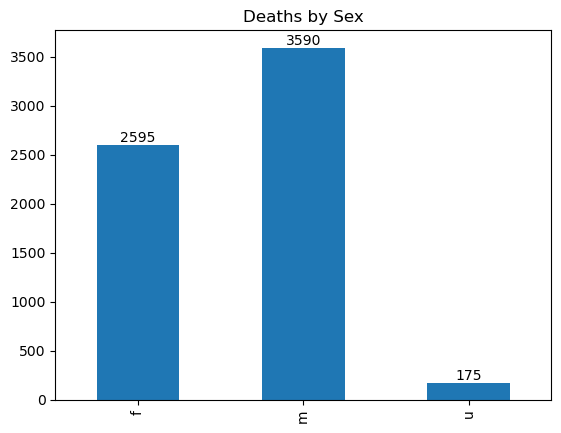

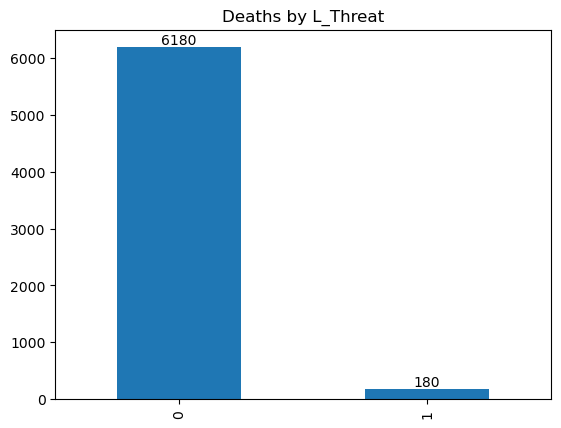

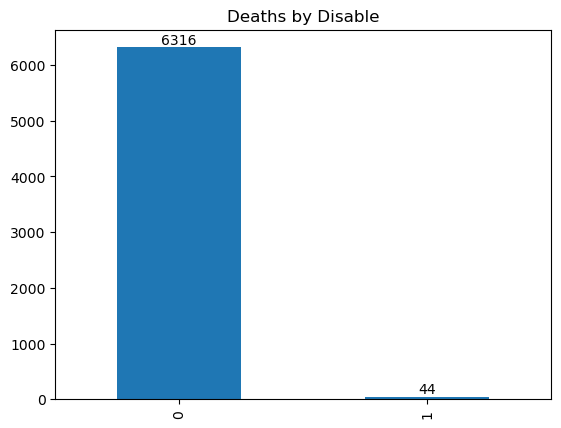

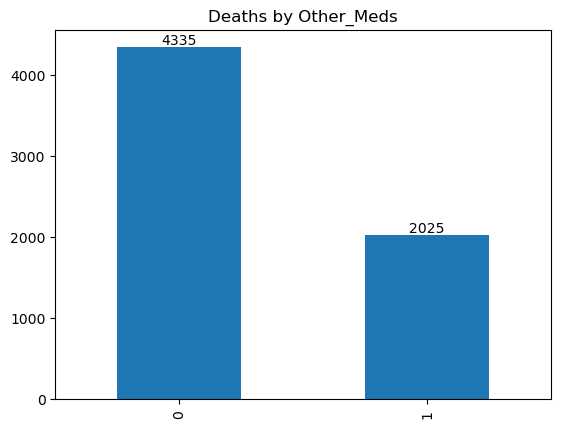

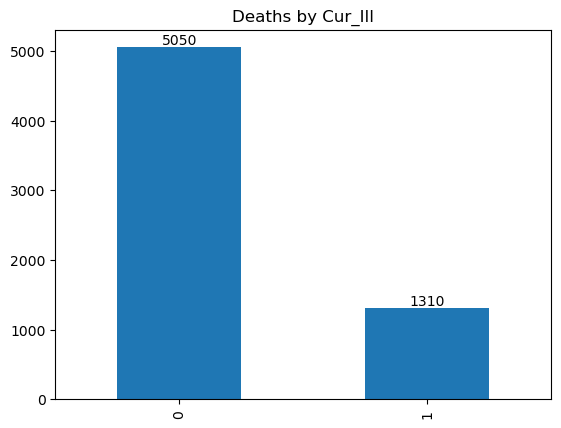

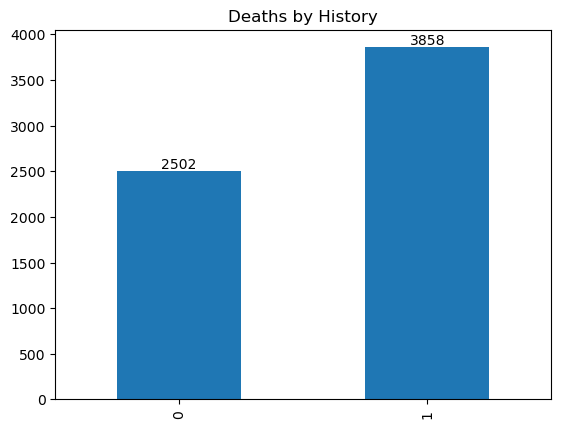

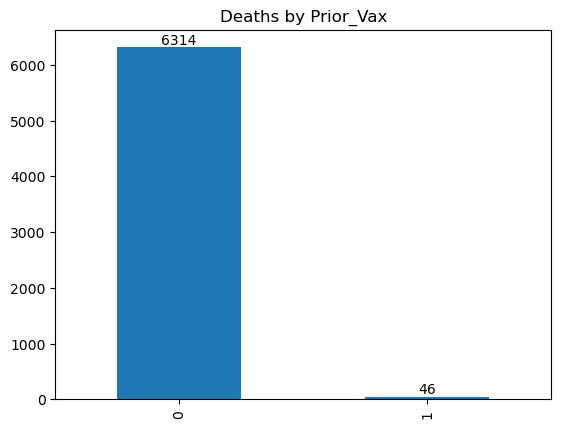

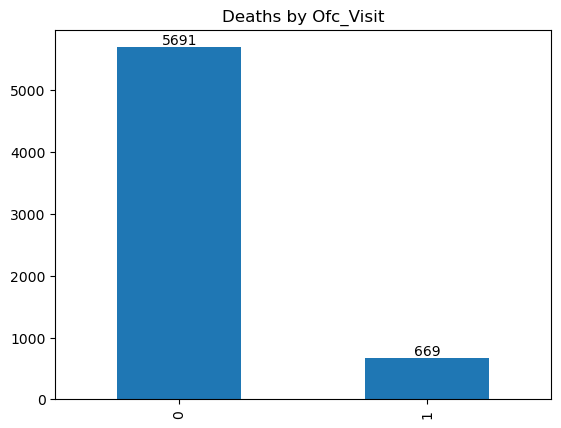

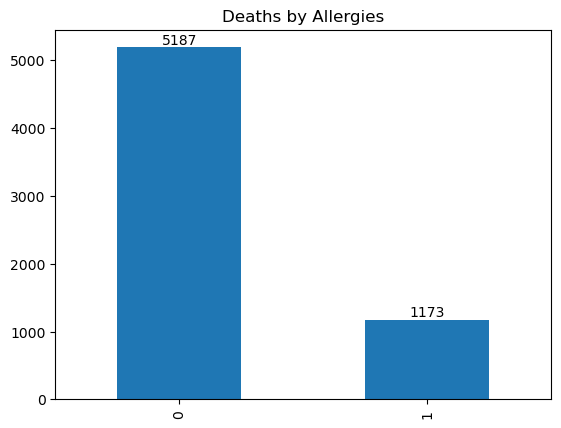

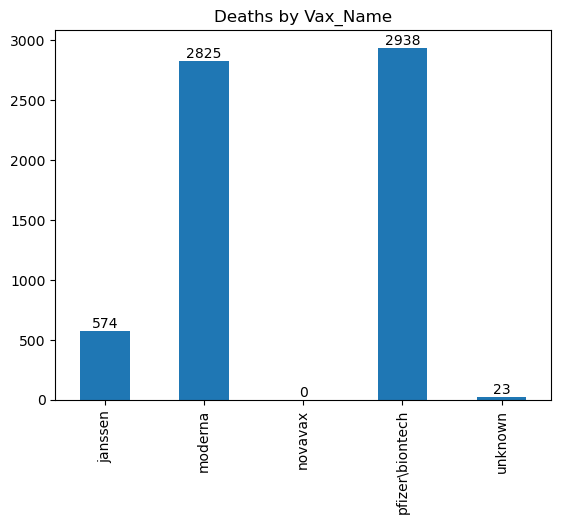

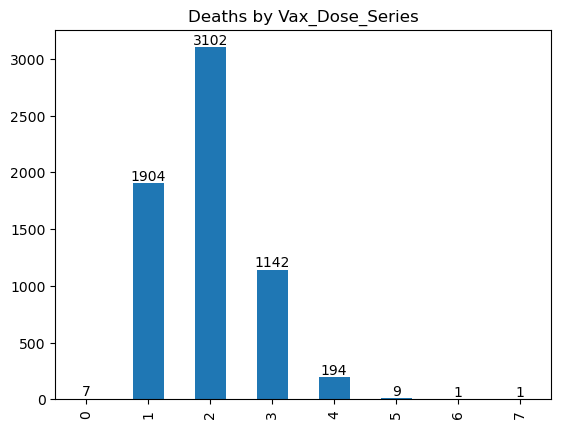

In [11]:
for feature in df.columns:
    if not feature in ['state', 'age_yrs', 'died']:
        ax = df.groupby(feature)['died'].sum().plot(kind='bar', x='feature')
        ax.set(xlabel=None)

        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'Deaths by {feature.title()}')
        plt.show()

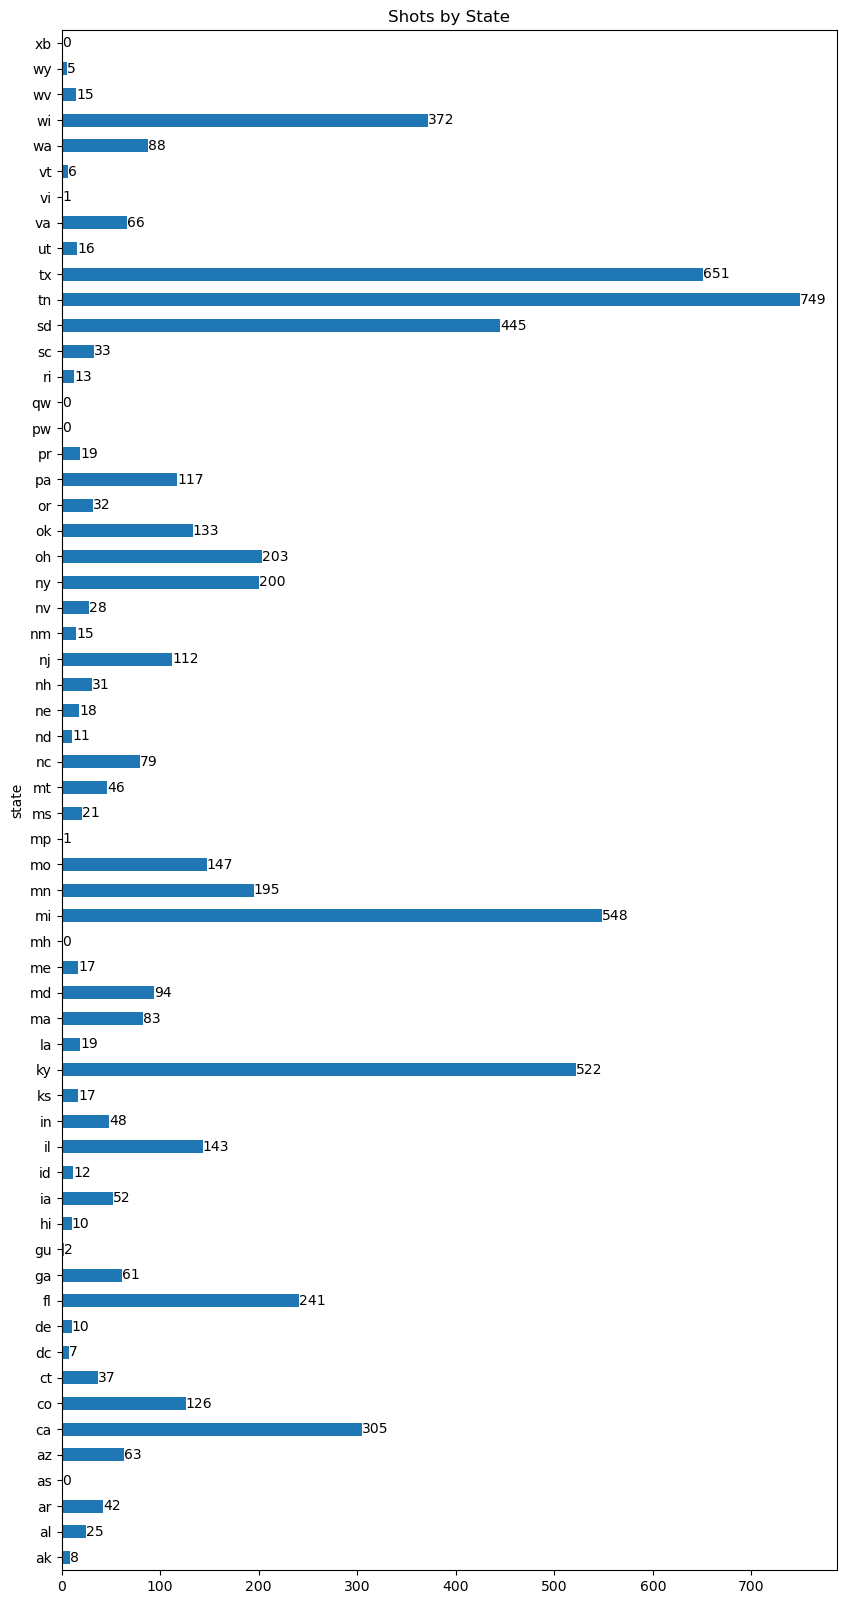

In [12]:
ax = df.groupby('state').died.sum().plot(kind='barh', y='state', figsize=(10, 20))

for container in ax.containers:
    ax.bar_label(container)
plt.title('Shots by State')
plt.show()

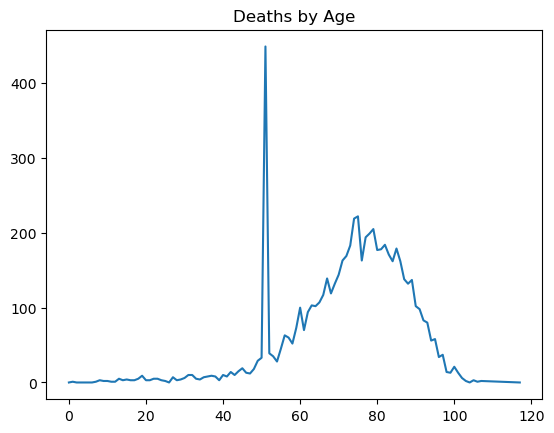

In [13]:
ax = df.groupby('age_yrs')['died'].sum().plot(kind='line', x='age_yrs')
ax.set(xlabel=None)

plt.title('Deaths by Age')
plt.show()

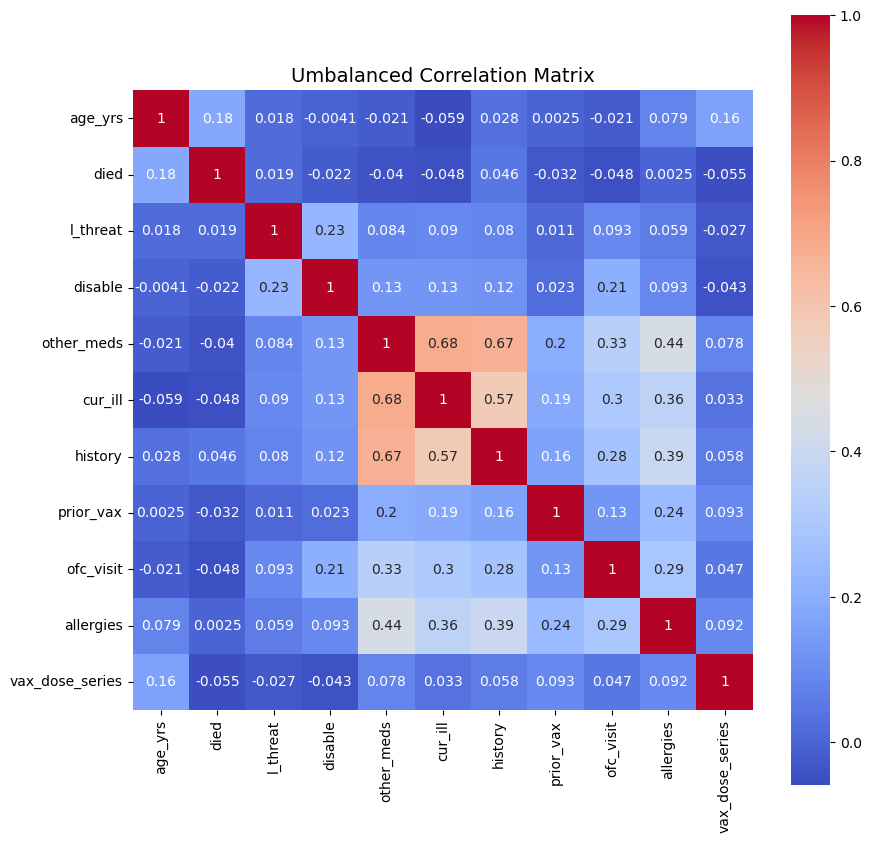

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm')
plt.title('Umbalanced Correlation Matrix', fontsize=14)
plt.show()

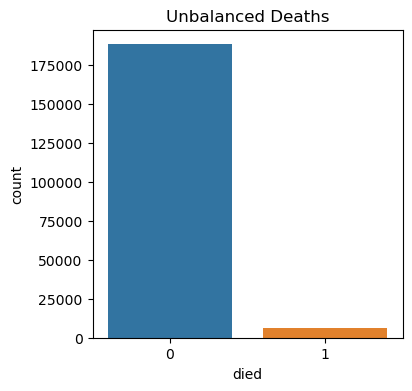

In [15]:
plt.figure(figsize=(4, 4))
sns.countplot(x='died', data=df)
plt.title('Unbalanced Deaths')
plt.show()

### Handle the hugely unbalanced dataset

In [16]:
# Balance the dataset
dead = df[df.died == 1].died.count()
shuffled_df = df.sample(frac=1, random_state=1)
dead_df = shuffled_df[shuffled_df['died'] == 1]
alive_df = shuffled_df[shuffled_df['died'] == 0].sample(n=dead, random_state=1)
vax_deaths_df = pd.concat([dead_df, alive_df])

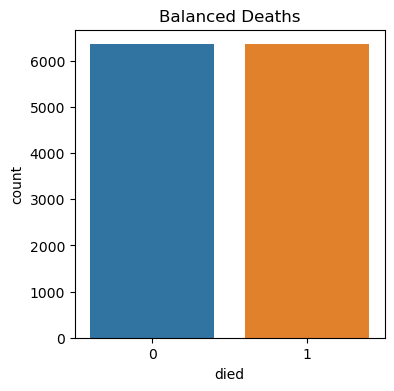

In [17]:
plt.figure(figsize=(4, 4))
sns.countplot(x='died', data=vax_deaths_df)
plt.title('Balanced Deaths')
plt.show()

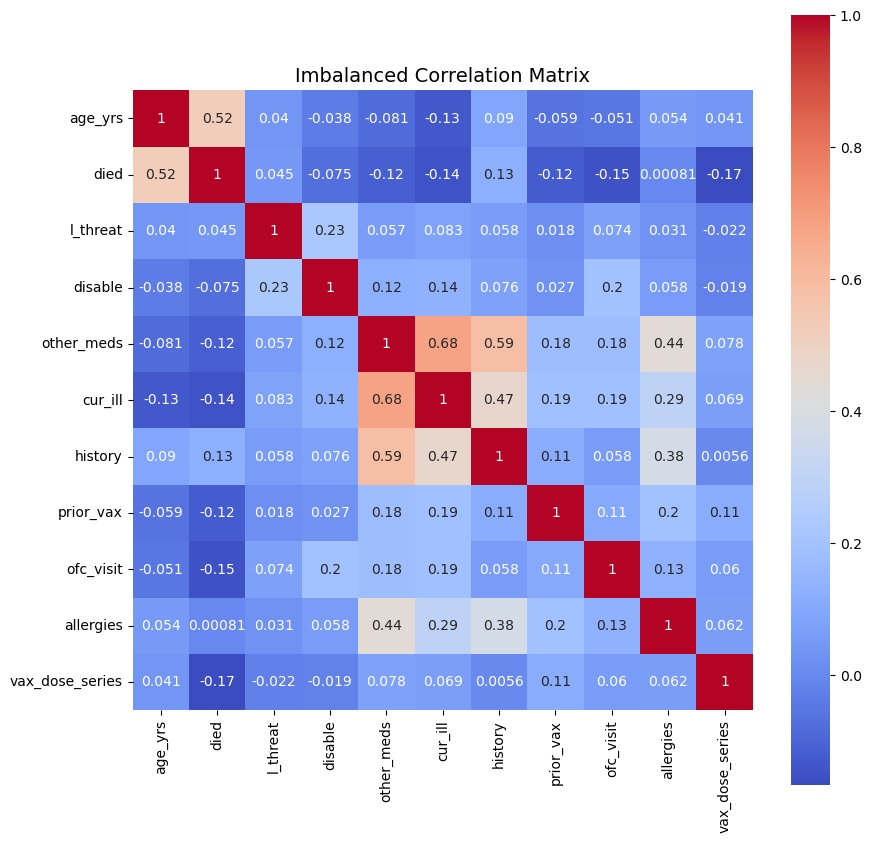

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(vax_deaths_df.corr(), annot=True, square=True, cmap='coolwarm')
plt.title('Imbalanced Correlation Matrix', fontsize=14)
plt.show()

## Model crossvalidation and selection

### Useful functions

In [19]:
def gen_conf_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(
                x=j,
                y=i,
                s=conf_matrix[i, j],
                va='center',
                ha='center',
                size='xx-large',
            )
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()


def mutual_info_died_score(series):
    return mutual_info_score(series, df_full_train.died)


def plot_auc_roc_curve(y_val, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    plt.figure(figsize=(5, 5))

    plt.plot(fpr, tpr, label='Model')
    plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title)

    plt.legend()


def test_rfc(estimators, depths=None):
    scores = []

    if depths is None:
        for n in tqdm(estimators):
            rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
            rf.fit(X_train, y_train)

            y_pred = rf.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)

            scores.append((n, auc))
        df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
        plt.plot(df_scores.n_estimators, df_scores.auc);
    else:
        for d in tqdm(depths):
            for n in tqdm(estimators):
                rf = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=d,
                    random_state=1,
                    n_jobs=-1,
                )
                rf.fit(X_train, y_train)

                y_pred = rf.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_pred)

                scores.append((d, n, auc))
        df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
        
        for d in depths:
            df_subset = df_scores[df_scores.max_depth == d]
            plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')
        plt.legend()
    
    best_score = df_scores[df_scores.auc == df_scores.auc.max()]
    display(best_score)

    return best_score


def test_rfc_with_max_depth(max_depth, estimators, leafs):
    scores = []

    for s in tqdm(leafs):
        for n in tqdm(estimators):
            rf = RandomForestClassifier(
                n_estimators=n,
                max_depth=max_depth,
                min_samples_leaf=s,
                random_state=1,
                n_jobs=-1,
            )
            rf.fit(X_train, y_train)

            y_pred = rf.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)

            scores.append((s, n, auc))
    
    df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
    
    best_score = df_scores[df_scores.auc == df_scores.auc.max()]
    display(best_score)

    return best_score


def test_trees(depths, leafs=None):
    scores = []
    if leafs is None:
        for depth in tqdm(depths):
            dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
            dt.fit(X_train, y_train)

            y_pred = dt.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)

            print('%4s -> %.3f' % (depth, auc))
    else:
        for depth in tqdm(depths):
            for s in tqdm(leafs):
                dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=1)
                dt.fit(X_train, y_train)

                y_pred = dt.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_pred)

                scores.append((depth, s, auc))

        columns = ['max_depth', 'min_samples_leaf', 'auc']
        df_scores = pd.DataFrame(scores, columns=columns)
        df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
        sns.heatmap(df_scores_pivot, annot=True, fmt=".3f");


def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    for t in thresholds:    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores


def plot_tpr_fpr(df_scores):
    plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
    plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
    plt.legend()


def train_xgboost_etas(etas):   
    evals_result = {}
    scores = {}

    for eta in etas:
        xgb_params = {
            'eta': eta, 
            'max_depth': 6,
            'min_child_weight': 1,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

        xgb_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
            evals_result=evals_result,
        )

        key = f'eta={xgb_params["eta"]}'

        columns = ['iter_num', 'train_auc', 'val_auc']
        train_aucs = list(evals_result['train'].values())[0]
        val_aucs = list(evals_result['val'].values())[0]

        df_scores = pd.DataFrame(
            list(zip(
                range(1, len(train_aucs)),
                train_aucs,
                val_aucs
            )), columns=columns)
        scores[key] = df_scores
    
    return scores


def train_xgboost_max_depths(eta, max_depths):   
    evals_result = {}
    scores = {}

    for max_depth in max_depths:
        xgb_params = {
            'eta': eta, 
            'max_depth': max_depth,
            'min_child_weight': 1,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

        xgb_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
            evals_result=evals_result,
        )

        key = f'depth={xgb_params["max_depth"]}'

        columns = ['iter_num', 'train_auc', 'val_auc']
        train_aucs = list(evals_result['train'].values())[0]
        val_aucs = list(evals_result['val'].values())[0]

        df_scores = pd.DataFrame(
            list(zip(
                range(1, len(train_aucs)),
                train_aucs,
                val_aucs
            )), columns=columns)
        scores[key] = df_scores
    
    return scores


def train_xgboost_min_child_weight(eta, max_depth, min_child_weights):   
    evals_result = {}
    scores = {}

    for min_child_weight in min_child_weights:
        xgb_params = {
            'eta': eta, 
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,

            'objective': 'binary:logistic',
            'eval_metric': 'auc',

            'nthread': 8,
            'seed': 1,
            'verbosity': 1,
        }

        xgb_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=200,
            verbose_eval=5,
            evals=watchlist,
            evals_result=evals_result,
        )

        key = f'min_child_weight={xgb_params["min_child_weight"]}'

        columns = ['iter_num', 'train_auc', 'val_auc']
        train_aucs = list(evals_result['train'].values())[0]
        val_aucs = list(evals_result['val'].values())[0]

        df_scores = pd.DataFrame(
            list(zip(
                range(1, len(train_aucs)),
                train_aucs,
                val_aucs
            )), columns=columns)
        scores[key] = df_scores
    
    return scores


def plot_xgboost(scores):
    for key, df_score in scores.items():
        plt.plot(df_score.iter_num, df_score.val_auc)
    plt.legend(scores.keys(), loc='best')
    plt.show()

### Split the data into training, validation, and testing sets

In [20]:
df_full_train, df_test = train_test_split(vax_deaths_df, test_size=0.2, random_state=1, stratify=vax_deaths_df.died)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train.died)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.died.values
y_val = df_val.died.values
y_test = df_test.died.values

del df_train['died']
del df_val['died']
del df_test['died']

In [21]:
global_died = df_full_train.died.mean()

for category in categorical:
    print(category)
    df_group = df_full_train.groupby(category).died.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_died
    df_group['risk'] = df_group['mean'] / global_died
    display(df_group)
    print()
    print()

state


,mean,count,diff,risk
state,,,,
ak,0.222222,18,-0.277778,0.444444
al,0.400000,55,-0.100000,0.800000
ar,0.568966,58,0.068966,1.137931
as,0.000000,3,-0.500000,0.000000
az,0.313253,166,-0.186747,0.626506
ca,0.309399,766,-0.190601,0.618799
co,0.291777,377,-0.208223,0.583554
ct,0.258065,124,-0.241935,0.516129
dc,0.176471,17,-0.323529,0.352941




sex


,mean,count,diff,risk
sex,,,,
f,0.413217,5024,-0.086783,0.826433
m,0.602820,4751,0.102820,1.205641
u,0.369077,401,-0.130923,0.738155




l_threat


,mean,count,diff,risk
l_threat,,,,
0,0.496737,9961,-0.003263,0.993475
1,0.651163,215,0.151163,1.302326




disable


,mean,count,diff,risk
disable,,,,
0,0.504695,10010,0.004695,1.009391
1,0.216867,166,-0.283133,0.433735




other_meds


,mean,count,diff,risk
other_meds,,,,
0,0.545753,6393,0.045753,1.091506
1,0.422680,3783,-0.077320,0.845361




cur_ill


,mean,count,diff,risk
cur_ill,,,,
0,0.543080,7428,0.043080,1.086160
1,0.383552,2748,-0.116448,0.767103




history


,mean,count,diff,risk
history,,,,
0,0.427193,4663,-0.072807,0.854386
1,0.561582,5513,0.061582,1.123163




prior_vax


,mean,count,diff,risk
prior_vax,,,,
0,0.510404,9900,0.010404,1.020808
1,0.126812,276,-0.373188,0.253623




ofc_visit


,mean,count,diff,risk
ofc_visit,,,,
0,0.532788,8555,0.032788,1.065576
1,0.326959,1621,-0.173041,0.653917




allergies


,mean,count,diff,risk
allergies,,,,
0,0.501144,8303,0.001144,1.002288
1,0.494928,1873,-0.005072,0.989856


In [22]:
df_full_train[categorical]

,state,sex,l_threat,disable,other_meds,cur_ill,history,prior_vax,ofc_visit,allergies
VAERS_ID,,,,,,,,,,
2400303,tx,m,0,0,1,1,1,0,0,0
2269045,mn,m,0,0,0,0,0,0,0,0
2104710,tn,f,0,0,1,0,1,0,0,1
2418347,tn,m,0,0,0,0,0,0,0,0
2155003,tx,f,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2422374,fl,m,0,0,0,0,0,0,0,0
2029246,tn,f,0,0,1,0,0,0,1,1
2223173,tx,m,0,0,0,0,0,0,0,0


In [23]:
mi = df_full_train[categorical].apply(mutual_info_died_score)
mi.sort_values(ascending=False)

state         0.093534
sex           0.018784
ofc_visit     0.011549
cur_ill       0.010104
history       0.008995
prior_vax     0.008696
other_meds    0.007097
disable       0.002820
l_threat      0.001002
allergies     0.000012
dtype: float64

In [24]:
df_full_train[numerical].corrwith(df_full_train.died).abs()

age_yrs            0.521645
vax_dose_series    0.169361
dtype: float64

In [25]:
df_full_train.age_yrs.max()

107

In [26]:
oldest = int(df_full_train.age_yrs.max())
for age in range(10, oldest, 5):
    rate = df_full_train[(df_full_train.age_yrs > age) & (df_full_train.age_yrs <= oldest)].died.mean()
    if rate == 1:
        print(f'{age}+ -> {rate:.3f}')
        break
    else:
        print(f'{age} -> {rate:.3f}')

10 -> 0.511
15 -> 0.521
20 -> 0.528
25 -> 0.536
30 -> 0.548
35 -> 0.560
40 -> 0.576
45 -> 0.594
50 -> 0.612
55 -> 0.671
60 -> 0.701
65 -> 0.739
70 -> 0.783
75 -> 0.824
80 -> 0.854
85 -> 0.873
90 -> 0.892
95 -> 0.922
100 -> 0.923
105+ -> 1.000


## Scale transform values

### DictVectorizer

In [27]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

### LogisticRegression

In [28]:
lr_model = LogisticRegression(C=0.1, max_iter=1_000, random_state=1, n_jobs=-1)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, random_state=1)

In [29]:
# score, y_pred = predict(X_val, lr_model)
y_pred = lr_model.predict_proba(X_val)[:, 1]
prediction = (y_pred >= 0.5)
(y_val == prediction).mean()

0.7995283018867925

In [30]:
thresholds = np.linspace(0.01, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print(f'{t:.2f} -> {score:.3f} +- {np.std(scores):.3f}')
    scores.append((t, score))

0.01 -> 0.510 +- nan
0.06 -> 0.594 +- 0.250
0.11 -> 0.647 +- 0.261
0.16 -> 0.688 +- 0.267
0.21 -> 0.716 +- 0.270
0.26 -> 0.743 +- 0.271
0.31 -> 0.753 +- 0.271
0.36 -> 0.775 +- 0.269
0.41 -> 0.790 +- 0.267
0.46 -> 0.796 +- 0.265
0.51 -> 0.800 +- 0.263
0.55 -> 0.785 +- 0.260
0.60 -> 0.785 +- 0.256
0.65 -> 0.775 +- 0.253
0.70 -> 0.766 +- 0.249
0.75 -> 0.745 +- 0.247
0.80 -> 0.726 +- 0.244
0.85 -> 0.689 +- 0.242
0.90 -> 0.631 +- 0.240
0.95 -> 0.559 +- 0.240
1.00 -> 0.500 +- 0.240


In [31]:
max(scores, key=lambda x: x[1])

(0.505, 0.7995283018867925)

In [32]:
threshold = max(scores, key=lambda x: x[1])[0]
lr_model = LogisticRegression(C=threshold, random_state=1)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8769984746449904

In [33]:
lr_model.score(X_test, y_test)

0.7952044025157232

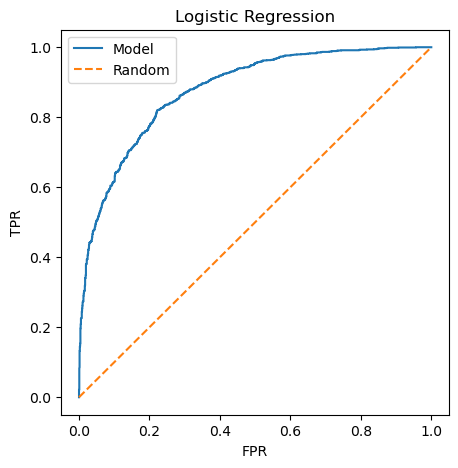

In [34]:
plot_auc_roc_curve(y_val, y_pred, 'Logistic Regression')

### Decision Tree

In [35]:
full_tree = DecisionTreeClassifier(random_state=1)
full_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [36]:
y_pred = full_tree.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7606002284324196

In [37]:
dt_methods = [
    'criterion',
    'get_depth',
    'get_n_leaves',
    'max_depth',
    'max_features_',
    'min_samples_leaf',
    'min_samples_split',
    'n_classes_',
    'n_features_',
    'n_features_in_',
    'n_outputs_',
    'splitter',
]

In [38]:
for m in dt_methods:
    meth = f'full_tree.{m}()'
    try:
        print(f'{m}:', eval(meth))
    except:
        meth = f'full_tree.{m}'
        print(f'{m}:', eval(meth))

criterion: gini
get_depth: 36
get_n_leaves: 1800
max_depth: None
max_features_: 72
min_samples_leaf: 1
min_samples_split: 2
n_classes_: 2
n_features_: 72
n_features_in_: 72
n_outputs_: 1
splitter: best


In [39]:
depths = [1, 5, 10, 15, 20, 25, 30, 35, 37, 38, 39, 40, 41, 42, 43, 45, 50, 55, 60, None]
test_trees(depths)

  0%|          | 0/20 [00:00<?, ?it/s]

   1 -> 0.718
   5 -> 0.835
  10 -> 0.840
  15 -> 0.796
  20 -> 0.762
  25 -> 0.765
  30 -> 0.761
  35 -> 0.758
  37 -> 0.761
  38 -> 0.761
  39 -> 0.761
  40 -> 0.761
  41 -> 0.761
  42 -> 0.761
  43 -> 0.761
  45 -> 0.761
  50 -> 0.761
  55 -> 0.761
  60 -> 0.761
None -> 0.761


In [40]:
depths = [11, 12, 13, 14, 15, 16, 17, 18, 19]
test_trees(depths)

  0%|          | 0/9 [00:00<?, ?it/s]

  11 -> 0.830
  12 -> 0.820
  13 -> 0.820
  14 -> 0.813
  15 -> 0.796
  16 -> 0.792
  17 -> 0.778
  18 -> 0.771
  19 -> 0.762


In [41]:
depths = [11, 12, 13, 14, 15, 16, 17]
test_trees(depths)

  0%|          | 0/7 [00:00<?, ?it/s]

  11 -> 0.830
  12 -> 0.820
  13 -> 0.820
  14 -> 0.813
  15 -> 0.796
  16 -> 0.792
  17 -> 0.778


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

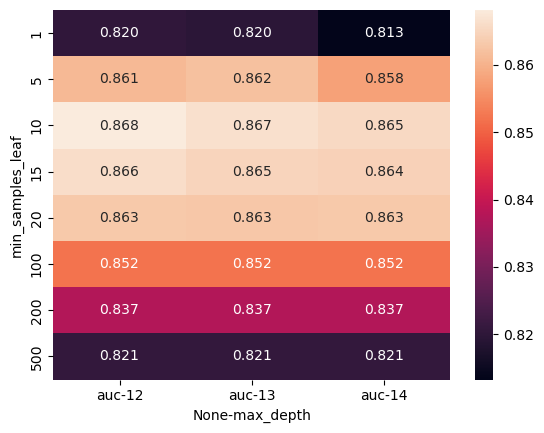

In [42]:
depths = [12, 13, 14]
leafs = [1, 5, 10, 15, 20, 500, 100, 200]
test_trees(depths, leafs)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

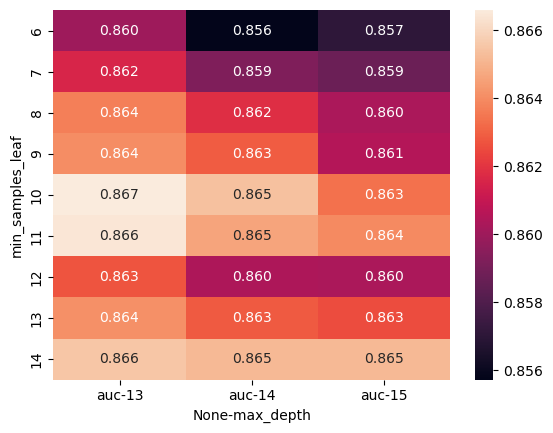

In [43]:
depths = [13, 14, 15]
leafs = [6, 7, 8, 9, 10, 11, 12, 13, 14]
test_trees(depths, leafs)

In [44]:
dt_model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=10, random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=10, random_state=1)

In [45]:
y_pred = dt_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8633543347771053

In [46]:
dt_model.score(X_test, y_test)

0.8022798742138365

In [47]:
for m in dt_methods:
    meth = f'dt_model.{m}()'
    try:
        print(f'{m}:', eval(meth))
    except:
        meth = f'dt_model.{m}'
        print(f'{m}:', eval(meth))

criterion: gini
get_depth: 15
get_n_leaves: 425
max_depth: 15
max_features_: 72
min_samples_leaf: 10
min_samples_split: 2
n_classes_: 2
n_features_: 72
n_features_in_: 72
n_outputs_: 1
splitter: best


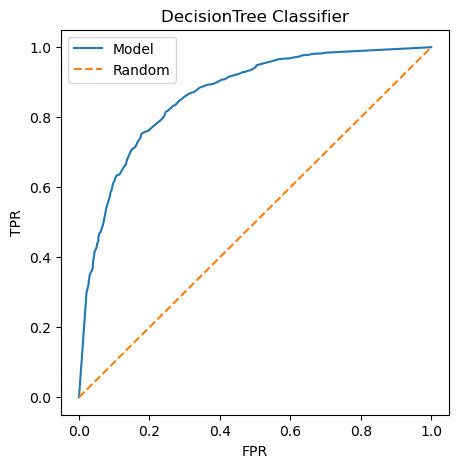

In [48]:
plot_auc_roc_curve(y_val, y_pred, 'DecisionTree Classifier')

In [49]:
print(export_text(dt_model, feature_names=dv.get_feature_names_out().tolist()))

|--- age_yrs <= 66.50
|   |--- age_yrs <= 48.50
|   |   |--- state=sd <= 0.50
|   |   |   |--- age_yrs <= 39.50
|   |   |   |   |--- history <= 0.50
|   |   |   |   |   |--- vax_name=pfizer\biontech <= 0.50
|   |   |   |   |   |   |--- age_yrs <= 19.50
|   |   |   |   |   |   |   |--- age_yrs <= 12.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- age_yrs >  12.50
|   |   |   |   |   |   |   |   |--- vax_dose_series <= 1.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- vax_dose_series >  1.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age_yrs >  19.50
|   |   |   |   |   |   |   |--- sex=m <= 0.50
|   |   |   |   |   |   |   |   |--- age_yrs <= 37.50
|   |   |   |   |   |   |   |   |   |--- age_yrs <= 29.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- age_yrs >  29.50
|   |   |   |   |   |   |   |   |   |   |--- age_yrs <= 31.50


### Random Forest Classifier

  0%|          | 0/18 [00:00<?, ?it/s]

,n_estimators,auc
13,140,0.887918


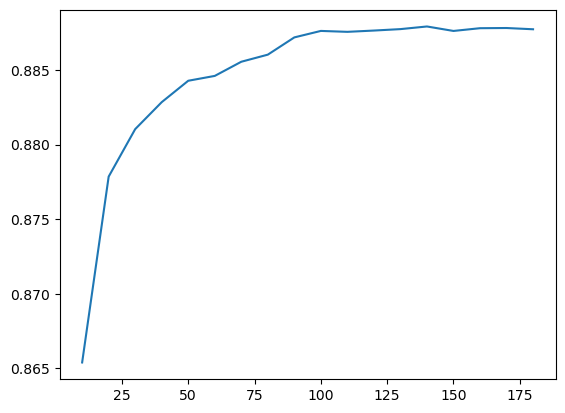

In [50]:
estimators = list(range(10, 181, 10))
best_est = test_rfc(estimators=estimators)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

,max_depth,n_estimators,auc
17,15,180,0.900518


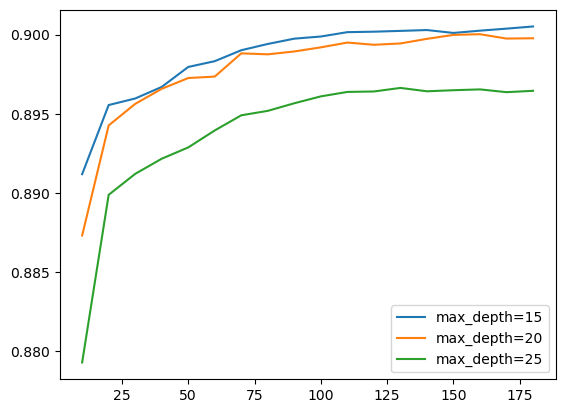

In [51]:
depths = [15, 20, 25]
best_depth = test_rfc(estimators=estimators, depths=depths)

In [52]:
estimators = list(
    range(best_est.n_estimators.values[0] - 10, best_est.n_estimators.values[0] + 10, 1)
)
max_depth = best_depth.max_depth.values[0]
leafs = [2, 3, 5, 7, 10, 50]

best_leafs = test_rfc_with_max_depth(max_depth=max_depth, estimators=estimators, leafs=leafs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

,min_samples_leaf,n_estimators,auc
19,2,149,0.898759


In [53]:
min_samples_leaf, n_estimator, *_ = map(int, best_leafs.values[0])
rf_model = RandomForestClassifier(
    n_estimators=n_estimator,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=1,
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=149,
                       n_jobs=-1, random_state=1)

In [54]:
y_pred = rf_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8987588876033384

In [55]:
rf_model.score(X_test, y_test)

0.8309748427672956

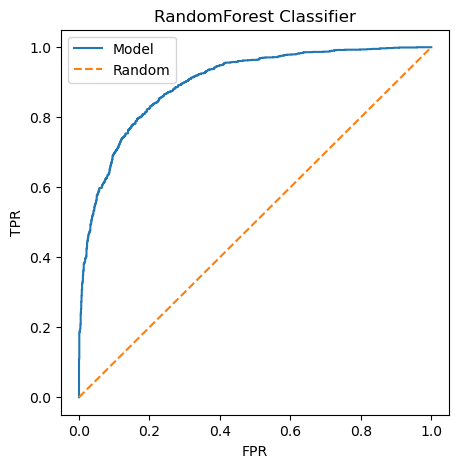

In [56]:
plot_auc_roc_curve(y_val, y_pred, 'RandomForest Classifier')

### Confusion matrix

In [57]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.55
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

conf_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
conf_matrix

array([[1069,  203],
       [ 277,  995]])

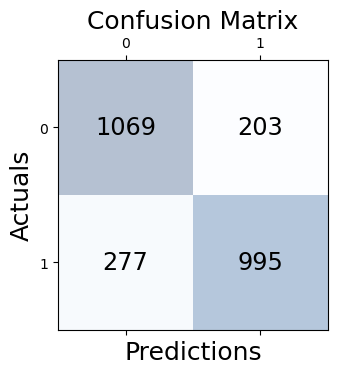

In [58]:
pred = (y_pred >= t).astype(int)
conf_matrix = confusion_matrix(y_true=y_val, y_pred=pred)
gen_conf_matrix(conf_matrix)

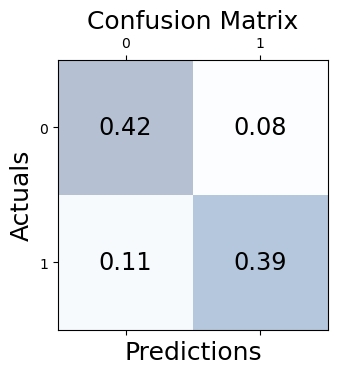

In [59]:
gen_conf_matrix((conf_matrix / conf_matrix.sum()).round(2))

#### Precision and Recall

In [60]:
p = tp / (tp + fp)
r = tp / (tp + fn)
tpr = tp / (tp + fn)   # same as recall
fpr = fp / (fp + tn)
print(f'          Precision: {p}')
print(f'             Recall: {r}')
print(f' True Positive Rate: {tpr}')
print(f'False Positive Rate: {tpr}')

          Precision: 0.830550918196995
             Recall: 0.7822327044025157
 True Positive Rate: 0.7822327044025157
False Positive Rate: 0.7822327044025157


### ROC Curve

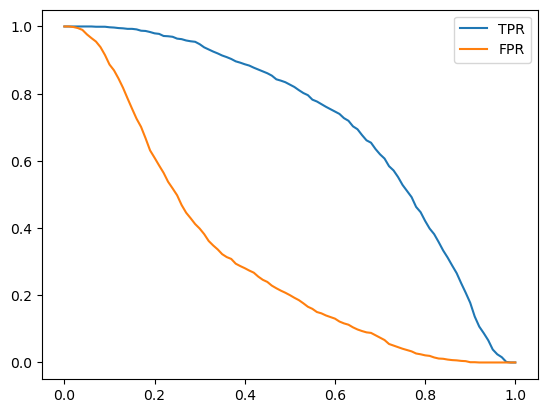

In [61]:
lr_scores = tpr_fpr_dataframe(y_val, y_pred)
plot_tpr_fpr(lr_scores)

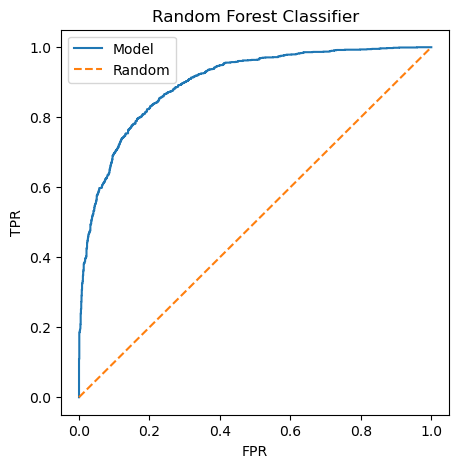

In [62]:
plot_auc_roc_curve(y_val, y_pred, 'Random Forest Classifier')

### XGBoost

In [63]:
features = dv.get_feature_names_out().tolist()

# cleanup feature names and values
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [64]:
%%capture output

etas = [0.01, 0.05, 0.1, 0.3, 1.0]
scores = train_xgboost_etas(etas)

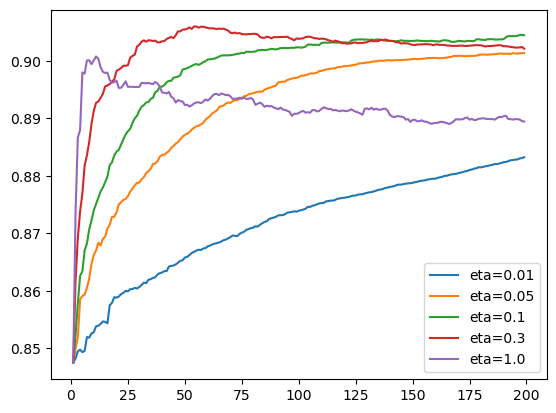

In [65]:
plot_xgboost(scores)

In [66]:
eta_aucs = [(tune, tmp_df.val_auc.max()) for tune, tmp_df in scores.items()]
eta = float(max(eta_aucs, key=lambda x: x[1])[0].split('=')[1])
eta

0.3

In [67]:
%%capture output

max_depths = [2, 5, 7, 10]
scores = train_xgboost_max_depths(eta, max_depths)

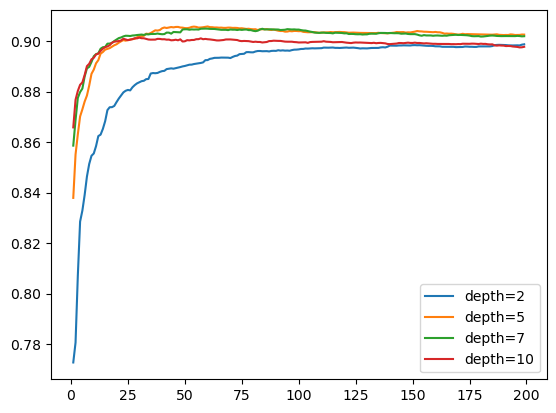

In [68]:
plot_xgboost(scores)

In [69]:
max_depth_aucs = [(tune, tmp_df.val_auc.max()) for tune, tmp_df in scores.items()]
max_depth = int(max(max_depth_aucs, key=lambda x: x[1])[0].split('=')[1])
max_depth

5

In [70]:
%%capture output

min_child_weight = [1, 2, 3]
scores = train_xgboost_min_child_weight(eta, max_depth, min_child_weight)

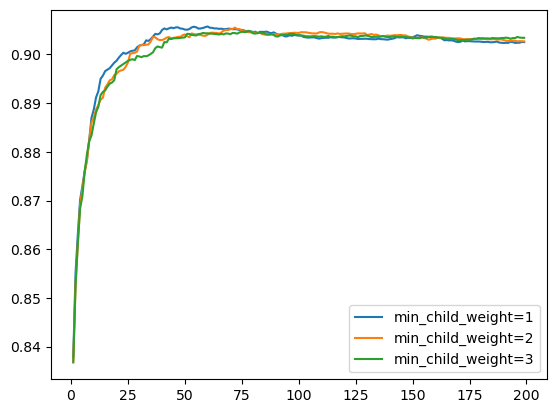

In [71]:
plot_xgboost(scores)

In [72]:
min_child_aucs = [(tune, tmp_df.val_auc.max()) for tune, tmp_df in scores.items()]
min_child_weight = int(max(min_child_aucs, key=lambda x: x[1])[0].split('=')[1])
min_child_weight

1

In [73]:
xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = xgb_model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8886666988054269

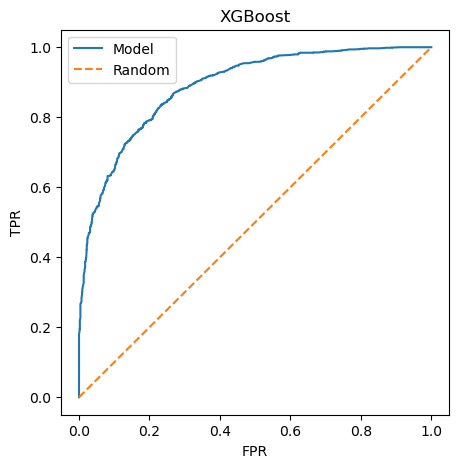

In [74]:
plot_auc_roc_curve(y_val, y_pred, 'XGBoost')

## Final Model

In [75]:
dfull_train = df_full_train.reset_index(drop=True)
# dfull_train.age_yrs = dfull_train.age_yrs.astype(np.int16)
yfull_train = (dfull_train.died == 1).astype(int).values
del dfull_train['died']

dicts_full_train = dfull_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
Xtest = dv.transform(dicts_test)

dfulltrain = xgb.DMatrix(
    X_full_train,
    label=yfull_train,
    feature_names=dv.get_feature_names_out().tolist(),
)
dfulltest = xgb.DMatrix(Xtest, feature_names=dv.get_feature_names_out().tolist())

In [76]:
eta, max_depth, min_child_weight

(0.3, 5, 1)

In [77]:
xgb_params = {
    'eta': eta, 
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [78]:
model = xgb.train(xgb_params, dfulltrain, num_boost_round=200)
y_pred = model.predict(dfulltest)
roc_auc_score(y_test, y_pred)

0.9122207018116373

In [79]:
sampe_count = df_test.shape[0] + 1
samples = random.sample(range(0, sampe_count), 10)

for n in samples:
    request = df_test.iloc[n].to_dict()
    print(json.dumps(request, indent=2))
    print(f'predicted: {y_pred[n]}')
    print(f'   actual: {y_test[n]}')
    print('---')

{
  "state": "co",
  "age_yrs": 67,
  "sex": "m",
  "l_threat": 0,
  "disable": 0,
  "other_meds": 0,
  "cur_ill": 0,
  "history": 0,
  "prior_vax": 0,
  "ofc_visit": 0,
  "allergies": 0,
  "vax_name": "moderna",
  "vax_dose_series": 2
}
predicted: 0.4186186194419861
   actual: 0
---
{
  "state": "fl",
  "age_yrs": 64,
  "sex": "m",
  "l_threat": 0,
  "disable": 0,
  "other_meds": 0,
  "cur_ill": 0,
  "history": 1,
  "prior_vax": 0,
  "ofc_visit": 0,
  "allergies": 0,
  "vax_name": "pfizer\\biontech",
  "vax_dose_series": 3
}
predicted: 0.33253321051597595
   actual: 0
---
{
  "state": "pa",
  "age_yrs": 72,
  "sex": "f",
  "l_threat": 0,
  "disable": 0,
  "other_meds": 1,
  "cur_ill": 0,
  "history": 0,
  "prior_vax": 1,
  "ofc_visit": 0,
  "allergies": 1,
  "vax_name": "pfizer\\biontech",
  "vax_dose_series": 4
}
predicted: 0.01755361258983612
   actual: 0
---
{
  "state": "ma",
  "age_yrs": 17,
  "sex": "m",
  "l_threat": 0,
  "disable": 0,
  "other_meds": 1,
  "cur_ill": 0,
  "hist